In [1]:
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier

np.random.seed(42)
dataset = pd.read_csv('HotDatasetS.csv')
dataset

,Age,Hours per day,BPM,Anxiety,Depression,Insomnia,OCD,Mental health score,Primary streaming service_Apple Music,Primary streaming service_I do not use a streaming service.,...,Frequency [Rock]_Rarely,Frequency [Rock]_Sometimes,Frequency [Rock]_Very frequently,Frequency [Video game music]_Never,Frequency [Video game music]_Rarely,Frequency [Video game music]_Sometimes,Frequency [Video game music]_Very frequently,Music effects_Improve,Music effects_No effect,Music effects_Worsen
0,-0.598806,0.159501,0.287691,0.406500,0.703560,2.012666,-0.226903,1.086242,-0.272289,-0.312996,...,2.671514,-0.648886,-0.912871,-0.675191,-0.620174,-0.589015,2.366432,-1.759702,1.889241,-0.160956
1,3.356381,-0.408280,-1.272932,1.134341,0.703560,-0.253729,0.125004,0.591815,-0.272289,-0.312996,...,-0.374320,-0.648886,-0.912871,1.481063,-0.620174,-0.589015,-0.422577,0.568278,-0.529313,-0.160956
2,-0.598806,0.159501,-0.525134,0.406500,-0.972120,0.393812,2.236451,0.715421,-0.272289,-0.312996,...,-0.374320,-0.648886,-0.912871,-0.675191,1.612452,-0.589015,-0.422577,0.568278,-0.529313,-0.160956
3,-0.598806,0.538022,-1.207906,0.770420,1.038696,1.041354,1.532635,1.580669,-0.272289,-0.312996,...,-0.374320,-0.648886,1.095445,1.481063,-0.620174,-0.589015,-0.422577,0.568278,-0.529313,-0.160956
4,-0.598806,-0.219019,-1.858165,-0.685261,1.038696,0.717583,-0.930719,0.097387,-0.272289,-0.312996,...,-0.374320,-0.648886,-0.912871,-0.675191,-0.620174,1.697749,-0.422577,0.568278,-0.529313,-0.160956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,-0.690787,-0.597540,-0.102465,0.406500,0.368424,-1.225042,2.236451,0.591815,-0.272289,-0.312996,...,-0.374320,-0.648886,1.095445,1.481063,-0.620174,-0.589015,-0.422577,0.568278,-0.529313,-0.160956
590,-0.598806,-0.976060,1.198054,-1.049181,-0.972120,-0.577500,0.828820,-0.644254,-0.272289,-0.312996,...,-0.374320,1.541104,-0.912871,-0.675191,-0.620174,1.697749,-0.422577,0.568278,-0.529313,-0.160956
591,-0.506825,0.916542,-0.102465,-1.413101,-0.972120,-0.577500,-0.226903,-1.138681,-0.272289,-0.312996,...,2.671514,-0.648886,-0.912871,-0.675191,1.612452,-0.589015,-0.422577,0.568278,-0.529313,-0.160956
592,-0.506825,0.538022,1.523183,-1.413101,-0.636984,-0.577500,-0.578811,-1.138681,-0.272289,-0.312996,...,-0.374320,-0.648886,-0.912871,-0.675191,-0.620174,1.697749,-0.422577,0.568278,-0.529313,-0.160956


Split 'Mental Health Score' into multiple categories of Mental Health

In [2]:
min_score = dataset['Mental health score'].min()
max_score = dataset['Mental health score'].max()
bins = [min_score, -1.5, -0.5, 0.5, max_score]
labels = ['Very low', 'Low', 'Moderate', 'High']
dataset['Mental health category'] = pd.cut(dataset['Mental health score'], bins=bins, labels=labels)

X = dataset.drop(['Mental health score', 'Mental health category'], axis=1) # X is the feature
y = dataset['Mental health category'] # y is the target variable
dataset
# This piece of code is common with Naive_Bayes.ipynb

,Age,Hours per day,BPM,Anxiety,Depression,Insomnia,OCD,Mental health score,Primary streaming service_Apple Music,Primary streaming service_I do not use a streaming service.,...,Frequency [Rock]_Sometimes,Frequency [Rock]_Very frequently,Frequency [Video game music]_Never,Frequency [Video game music]_Rarely,Frequency [Video game music]_Sometimes,Frequency [Video game music]_Very frequently,Music effects_Improve,Music effects_No effect,Music effects_Worsen,Mental health category
0,-0.598806,0.159501,0.287691,0.406500,0.703560,2.012666,-0.226903,1.086242,-0.272289,-0.312996,...,-0.648886,-0.912871,-0.675191,-0.620174,-0.589015,2.366432,-1.759702,1.889241,-0.160956,High
1,3.356381,-0.408280,-1.272932,1.134341,0.703560,-0.253729,0.125004,0.591815,-0.272289,-0.312996,...,-0.648886,-0.912871,1.481063,-0.620174,-0.589015,-0.422577,0.568278,-0.529313,-0.160956,High
2,-0.598806,0.159501,-0.525134,0.406500,-0.972120,0.393812,2.236451,0.715421,-0.272289,-0.312996,...,-0.648886,-0.912871,-0.675191,1.612452,-0.589015,-0.422577,0.568278,-0.529313,-0.160956,High
3,-0.598806,0.538022,-1.207906,0.770420,1.038696,1.041354,1.532635,1.580669,-0.272289,-0.312996,...,-0.648886,1.095445,1.481063,-0.620174,-0.589015,-0.422577,0.568278,-0.529313,-0.160956,High
4,-0.598806,-0.219019,-1.858165,-0.685261,1.038696,0.717583,-0.930719,0.097387,-0.272289,-0.312996,...,-0.648886,-0.912871,-0.675191,-0.620174,1.697749,-0.422577,0.568278,-0.529313,-0.160956,Moderate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,-0.690787,-0.597540,-0.102465,0.406500,0.368424,-1.225042,2.236451,0.591815,-0.272289,-0.312996,...,-0.648886,1.095445,1.481063,-0.620174,-0.589015,-0.422577,0.568278,-0.529313,-0.160956,High
590,-0.598806,-0.976060,1.198054,-1.049181,-0.972120,-0.577500,0.828820,-0.644254,-0.272289,-0.312996,...,1.541104,-0.912871,-0.675191,-0.620174,1.697749,-0.422577,0.568278,-0.529313,-0.160956,Low
591,-0.506825,0.916542,-0.102465,-1.413101,-0.972120,-0.577500,-0.226903,-1.138681,-0.272289,-0.312996,...,-0.648886,-0.912871,-0.675191,1.612452,-0.589015,-0.422577,0.568278,-0.529313,-0.160956,Low
592,-0.506825,0.538022,1.523183,-1.413101,-0.636984,-0.577500,-0.578811,-1.138681,-0.272289,-0.312996,...,-0.648886,-0.912871,-0.675191,-0.620174,1.697749,-0.422577,0.568278,-0.529313,-0.160956,Low


Create pipelines and split training/testing/validation sets

In [3]:
le = LabelEncoder()
y = le.fit_transform(y)
# Encoded a unique value to the categories, such that
# 0 - [Zero Category]
# 1 - [Very Low 0-10]
# 2 - [Low 10-20]
# 3 - [Moderate 20-30]
# 4 - [High 30-40]

# Split the dataset into train, test and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
# Splitting test set in half, one half remains in test set and the other goes to the validation set

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    # SimpleImputer replaces all missing values with the median
    ('scaler', StandardScaler())])
    # StandardScaler makes each feature have a standard deviation of 1 and a mean of 0

    # NOTE: StandardScaler does not modify the data, it only transforms it to be easier to read by a Machine Learning model.
    # This means the data sent into the model is the exact same as the dataset, only its been standardized
    # More info on https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # This instance of SimpleImputer replaces missing values with the one that appears most frequently
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    # Performs OneHotEncoding on categorical values in X
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, X.select_dtypes(include=['int64', 'float64']).columns),
        ('cat', categorical_transformer, X.select_dtypes(include=['object']).columns)
    ]
)

# This piece of code is common with Naive_Bayes.ipynb

Use GridSearchCV to find best estimator/best parameters

In [4]:
pipeline_mlp = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', MLPClassifier(random_state=42))])

param_grid = {
    'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)], # 4 combinations
    'classifier__activation': ['relu', 'tanh'], # 2 combinations
    'classifier__alpha': [0.0001, 0.001, 0.01], # 3 Combinations
    'classifier__learning_rate': ['constant', 'adaptive'], # 2 Combinations
}
# 4*2*3*2 = 48
# There are 48 possible combinations for hyperparameters

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    # Ignoring warnings that could make the logs unreadable, mainly ConvergenceWarning
    grid_search = GridSearchCV(pipeline_mlp, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

best_mlp_model = grid_search.best_estimator_
# best_estimator_ is a new estimator which the GridSearch found gave the highest scores
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'classifier__activation': 'tanh', 'classifier__alpha': 0.0001, 'classifier__hidden_layer_sizes': (100, 50), 'classifier__learning_rate': 'constant'}


Predict on testing set

In [5]:
y_pred_mlp = best_mlp_model.predict(X_test)
accuracy_mlp = accuracy_score(y_test, y_pred_mlp) * 100
print("MLP Classifier Testing Set Metrics:")
print("Accuracy: ", accuracy_mlp, "%", sep="")

MLP Classifier Testing Set Metrics:
Accuracy: 73.03370786516854%


Predict on Validation Set

In [6]:
y_pred_mlp_valid = best_mlp_model.predict(X_valid)
accuracy_mlp_valid = accuracy_score(y_valid, y_pred_mlp_valid) * 100
print("MLP Classifier Validation Set Metrics:")
print("Accuracy: ", accuracy_mlp_valid, "%", sep="")

MLP Classifier Validation Set Metrics:
Accuracy: 72.22222222222221%


Confusion Matrix

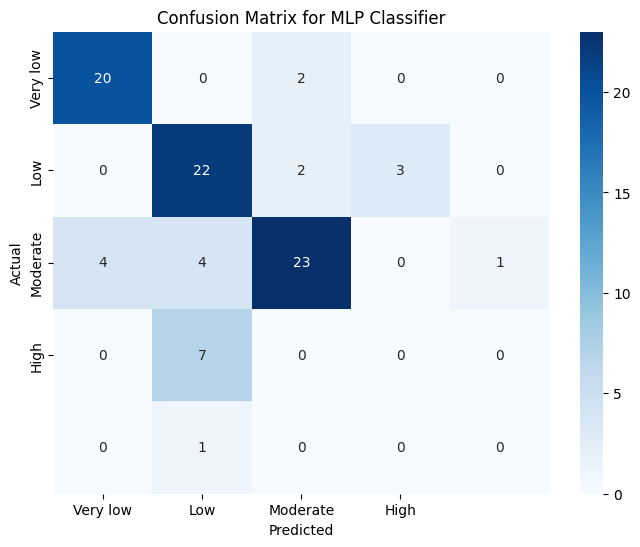

In [7]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_mlp)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for MLP Classifier')
plt.show()

Creating a table and a scatter plot out of the Actual Value vs. Predicted Value

In [12]:
reg_model_diff = pd.DataFrame({'Actual value': y_test, 'Predicted value': y_pred_mlp})
reg_model_diff

,Actual value,Predicted value
0,4,1
1,2,2
2,0,0
3,3,1
4,0,0
...,...,...
84,2,1
85,1,1
86,2,1
87,0,0


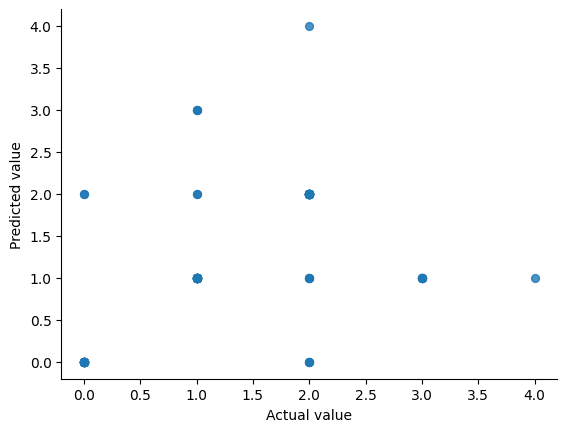

In [13]:
reg_model_diff.plot(kind='scatter', x='Actual value', y='Predicted value', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

Classification Report

In [8]:
print("Classification Report for MLP Classifier:")
labels = ['Zero Category', 'Very Low', 'Low', 'Moderate', 'High']
print(classification_report(y_test, y_pred_mlp, target_names=labels))

Classification Report for MLP Classifier:
               precision    recall  f1-score   support

Zero Category       0.83      0.91      0.87        22
     Very Low       0.65      0.81      0.72        27
          Low       0.85      0.72      0.78        32
     Moderate       0.00      0.00      0.00         7
         High       0.00      0.00      0.00         1

     accuracy                           0.73        89
    macro avg       0.47      0.49      0.47        89
 weighted avg       0.71      0.73      0.71        89



 OLAP Q.6: How does music preferences (genres of music) relate to mental health outcomes?

In [9]:
filtered_columns = ['Fav genre_Country', 'Fav genre_Video game music', 'Fav genre_Metal', 'Fav genre_Pop',
                    'Fav genre_EDM', 'Fav genre_R&B', 'Fav genre_K pop', 'Fav genre_Hip hop',
                    'Fav genre_Folk', 'Fav genre_Jazz','Fav genre_Latin', 'Fav genre_Lofi',
                    'Fav genre_Rap', 'Fav genre_Rock', 'Fav genre_Classical','Fav genre_Gospel', 'Mental health score']

dataset['Music Genre Combination'] = dataset[filtered_columns[:-1]].applymap(lambda x: 1 if x else 0).astype(str).agg('_'.join, axis=1) # Music Genre Combination
dataset['Favorite Genre'] = dataset[filtered_columns[:-1]].idxmax(axis=1).str.replace('Fav genre_', '') # Favorite Genre Column
average_mental_health_score = dataset.groupby(['Music Genre Combination', 'Favorite Genre'])['Mental health score'].mean().reset_index() # Mental Health Score column

print("Average Mental Health Score for each Favorite Music Genre Combination:\n")
print(average_mental_health_score)


Average Mental Health Score for each Favorite Music Genre Combination:

            Music Genre Combination    Favorite Genre  Mental health score
0   1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1         Classical            -0.156694
1   1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1           Country            -0.273433
2   1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1               EDM            -0.033491
3   1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1              Folk             0.154040
4   1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1            Gospel            -0.809063
5   1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1           Hip hop             0.185108
6   1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1              Jazz            -0.053688
7   1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1             K pop            -0.063302
8   1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1             Latin            -0.088023
9   1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1              Lofi             0.554733
10  1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1             Metal            -0.008810
11  1_1_1_1_1_1_1_1_1_1_1_1_

OLAP Q.7: How does the BPM of music relate to the mental health of individuals? Are there specific ranges of BPM associated with lower (or higher) levels of mental health issues?

Average BPM for each mental health category:

Mental health category
Very low   -0.134978
Low        -0.062125
Moderate    0.089208
High        0.001543
Name: BPM, dtype: float64

Correlation between BPM & Mental Health Score: 0.06858666274887804 

There is a positive correlation between BPM and mental health.


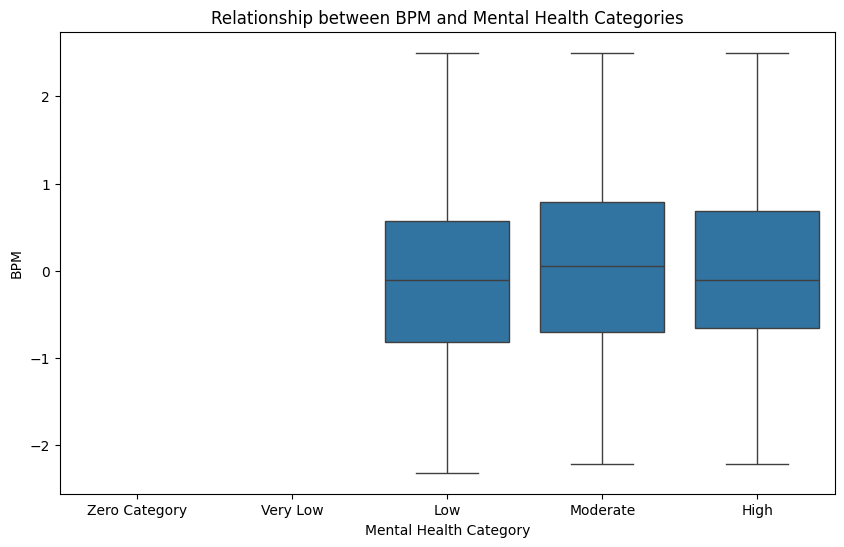

In [10]:
bpm_by_category = dataset.groupby('Mental health category')['BPM'].mean()

print("Average BPM for each mental health category:\n")
print(bpm_by_category)

correlation = dataset['BPM'].corr(dataset['Mental health score'])
print("\nCorrelation between BPM & Mental Health Score:",correlation,"\n")
if correlation > 0:
    print("There is a positive correlation between BPM and mental health.")
elif correlation < 0:
    print("There is a negative correlation between BPM and mental health.")
else:
    print("There is no significant correlation between BPM and mental health.")

plt.figure(figsize=(10, 6))
sns.boxplot(x='Mental health category', y='BPM', data=dataset, order=labels)
plt.title('Relationship between BPM and Mental Health Categories')
plt.xlabel('Mental Health Category')
plt.ylabel('BPM')
plt.show()